In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../'))  # for importing local packages from src

%reload_ext autoreload
%autoreload 2 

### Loading the datasets

Currently we are loading the HydroShoot dataset generated during the first semester.

In [2]:
from src.model.rc_dataset import ExperimentDataset


DATASET_PATH = 'datasets/hydroshoot_large_trimmed.csv'

dataset = ExperimentDataset(csv_path=DATASET_PATH)
print(dataset)

datasets = (dataset,)

Dataset properties:
	n_runs:      84
	n_steps:    168
	state_size: 360

Available targets: 
	input_Tac, input_u, input_hs, input_Rg, output_Rg, output_An, output_E, output_Tleaf

Available state variables: 
	state_An, state_E, state_Eabs, state_Ei, state_Flux, state_FluxC, state_Tlc, state_gb, state_gs, state_psi_head, state_u



### Target generators

In [3]:
from model_config_hydroshoot import targets
from pipeline_hydroshoot import TargetGenerator


all_run_ids = dataset.get_run_ids()
target_generator = TargetGenerator(target=targets[0], run_ids=all_run_ids)
y_raw = target_generator.transform(datasets)

print(f'y_raw shape: {y_raw.shape}')

y_raw shape: (84, 168)


### Reservoir generators

#### Single state, random subset

X_raw shape: (84, 168, 16)


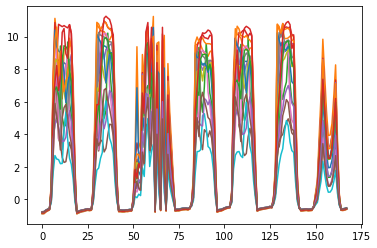

In [4]:
from model_config_hydroshoot import state_variables
from pipeline_hydroshoot import SingleReservoirGenerator

np.random.seed(42)
state_ids = np.random.choice(dataset.state_size(), size=16, replace=False)
res_generator = SingleReservoirGenerator(
  state_var=state_variables[0], run_ids=all_run_ids, state_ids=state_ids
)
X_raw = res_generator.transform(datasets)

print(f'X_raw shape: {X_raw.shape}')

plt.plot(X_raw[0])
plt.show()

#### Multi state, random subset

X_raw shape: (84, 168, 176)


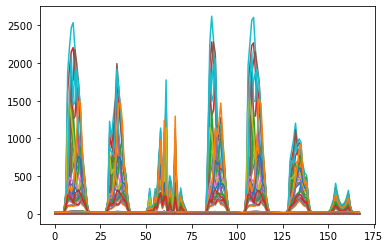

In [5]:
from pipeline_hydroshoot import MultiReservoirGenerator


res_generator = MultiReservoirGenerator(
  state_vars=state_variables, run_ids=all_run_ids, state_ids=state_ids
)
X_raw = res_generator.transform(datasets)

print(f'X_raw shape: {X_raw.shape}')

plt.plot(X_raw[0])
plt.show()

#### Environmental baseline reservoir

X_raw shape: (84, 168, 4)


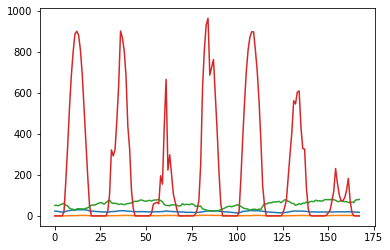

In [6]:
from pipeline_hydroshoot import TargetReservoirGenerator

env_targets = ['input_Tac', 'input_u', 'input_hs', 'input_Rg']
res_generator = TargetReservoirGenerator(targets=env_targets, run_ids=all_run_ids)
X_raw = res_generator.transform(datasets)

print(f'X_raw shape: {X_raw.shape}')

plt.plot(X_raw[0])
plt.show()


### Group generator

In [11]:
from pipeline_hydroshoot import GroupGenerator

group_gen = GroupGenerator(day_length=24, run_ids=all_run_ids, days_between_runs=1)
groups_raw = group_gen.transform(datasets)

print(f'groups_raw shape: {groups_raw.shape}')
print(f'n_groups: {np.unique(groups_raw).shape}')

print(groups_raw[:5, ::24])

groups_raw shape: (84, 168)
n_groups: (90,)
[[ 0.  1.  2.  3.  4.  5.  6.]
 [ 1.  2.  3.  4.  5.  6.  7.]
 [ 2.  3.  4.  5.  6.  7.  8.]
 [ 3.  4.  5.  6.  7.  8.  9.]
 [ 4.  5.  6.  7.  8.  9. 10.]]


### Mask generator

In [32]:
from pipeline_hydroshoot import TimeGenerator

time_gen = TimeGenerator(day_length=24, run_ids=all_run_ids)
time_raw = time_gen.transform(datasets)

print(f'Shape: {time_raw.shape}')

print(time_raw[0:3, 0:72:12])


Shape: (84, 168)
[[ 0 12  0 12  0 12]
 [ 0 12  0 12  0 12]
 [ 0 12  0 12  0 12]]


### Transformers

#### Direct target (no transform)

In [33]:
from pipeline_base import DirectTransform

target_tf = DirectTransform()
X_tf, y_tf, groups_tf, time_tf = target_tf.transform(X_raw, y_raw, groups_raw, time_raw)

print(X_tf.shape, y_tf.shape, groups_tf.shape)

(84, 168, 4) (84, 168) (84, 168)


In [38]:
from pipeline_base import WarmupTransform

target_tf = WarmupTransform(warmup_days=4, day_length=24)
X_tf, y_tf, groups_tf, time_tf = target_tf.transform(X_raw, y_raw, groups_raw, time_raw)

print(X_tf.shape, y_tf.shape, groups_tf.shape, time_tf.shape)


(84, 72, 4) (84, 72) (84, 72) (84, 72)


### Flatten data

In [40]:
from pipeline_base import flatten

X, y, groups, time = flatten(X_tf, y_tf, groups_tf, time_tf)

print(X.shape)
print(y.shape)
print(groups.shape)
print(time.shape)

(6048, 4)
(6048,)
(6048,)
(6048,)


### Data preprocessors

#### Daylight masking

In [44]:
from pipeline_base import DaylightMask

day_mask_tf = DaylightMask(day_length=24, start=5, end=21)
X_day, y_day, groups_day, time_day = day_mask_tf.transform(X, y, groups, time) 

print(X_day.shape, y_day.shape, groups_day.shape, time_day.shape)

(4032, 4) (4032,) (4032,) (4032,)


#### Rescaling

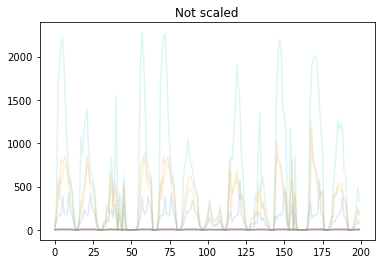

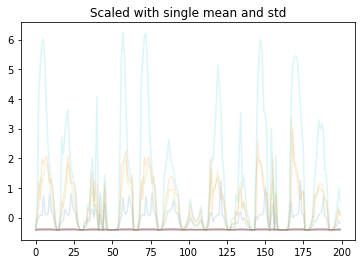

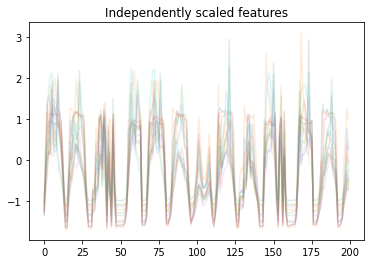

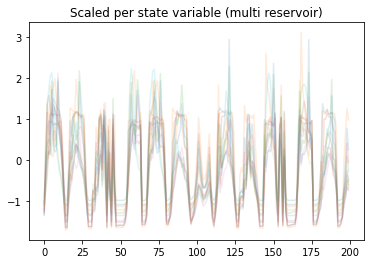

In [49]:
from pipeline_base import Rescale
from pipeline_hydroshoot import GroupRescale

reservoir_generator = MultiReservoirGenerator(state_vars=state_variables[:3], state_ids=state_ids[:4], run_ids=all_run_ids)
X_raw = reservoir_generator.transform(datasets)
X, y, groups, time = flatten(X_raw, y_raw, groups_raw, time_raw)

X, y, groups, time = day_mask_tf.transform(X, y, groups, time)

plt.plot(X[:200], alpha=0.15)
plt.title('Not scaled')
plt.show()

scaler_tf = Rescale(per_feature=False)
X_scaled, _, _, _ = scaler_tf.transform(X, y, groups, time)

plt.plot(X_scaled[:200], alpha=0.15)
plt.title('Scaled with single mean and std')
plt.show()

scaler_tf = Rescale(per_feature=True)
X_scaled, _, _, _ = scaler_tf.transform(X, y, groups, time)

plt.plot(X_scaled[:200], alpha=0.15)
plt.title('Independently scaled features')
plt.show()

scaler = GroupRescale(datasets=datasets, state_vars=state_variables[:3], state_ids=state_ids[:4])
X_, y_, groups_, _ = scaler.transform(X, y, groups, time)

plt.plot(X_scaled[:200], alpha=0.15)
plt.title('Scaled per state variable (multi reservoir)')
plt.show()

### Train-test splitter

In [50]:
from pipeline_base import TrainTestSplitter

splitter = TrainTestSplitter(block_size=4, test_ratio=0.5)
train, test = splitter.transform(X, y, groups)

print(train[0].shape, test[0].shape)

(4688, 12) (4720, 12)


### Pipeline definition

In [54]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold

from src.learning.scorers import nmse_scorer

from pipeline_base import RCPipeline


# Reservoir definition
datasets = (dataset,)
np.random.seed(42)
state_ids = np.random.choice(dataset.state_size(), size=16, replace=False)
run_ids = dataset.get_run_ids()

reservoir_id = 'state__het_all'
reservoir = MultiReservoirGenerator(state_vars=state_variables, run_ids=run_ids, state_ids=state_ids)

# Target definition
target_id = 'input_Tac'
target = TargetGenerator(target=target_id, run_ids=run_ids)

# Model definition
readout = Pipeline([
  ('ridge_regression', Ridge(alpha=1, fit_intercept=True))
])

search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-4), np.log10(1e2), 50)
}]

pipeline = RCPipeline(
  # Metadata
  metadata={
    'target_id': target_id,
    'reservoir_id': reservoir_id,
    'dataset_id': 'HydroShoot_large',
  },

  # Data generation
  datasets=datasets,
  target=target,
  reservoir=reservoir,
  groups=GroupGenerator(day_length=24, run_ids=run_ids, days_between_runs=1),
  time=TimeGenerator(day_length=24, run_ids=run_ids),

  # Data transformation
  transforms=[
    DirectTransform()
  ],

  # Data preprocessing
  preprocessing=[
    DaylightMask(day_length=24, start=5, end=21),
    # Rescale(per_feature=True)
    GroupRescale(datasets=datasets, state_vars=state_variables, state_ids=state_ids)
  ],

  # Model training and testing
  train_test_split=TrainTestSplitter(block_size=4, test_ratio=0.5),
  readout_model=readout,
  model_param_grid=search_grid,
  model_scorer=nmse_scorer,
  folds=GroupKFold(n_splits=5),
)

### Pipeline execution

In [58]:
from pipeline_base import execute_pipeline

results = execute_pipeline(pipeline)

print(results)

{'target_id': 'input_Tac', 'reservoir_id': 'state__het_all', 'dataset_id': 'HydroShoot_large', 'test_score': -0.37459996461858813, 'train_mean': -0.37661041318851235, 'train_std': 0.0074297035497442555, 'cv_mean': -0.4045318205837824, 'cv_std': 0.01919770963888103}
